Tensor Field Networks

Implementation of shape classification demonstration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import tensorflow as tf
import random
from math import pi, sqrt
import tensorfieldnetworks.layers as layers
import tensorfieldnetworks.utils as utils
from tensorfieldnetworks.utils import FLOAT_TYPE
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tetris = [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 0)],  # chiral_shape_1
          [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, -1, 0)], # chiral_shape_2
          [(0, 0, 0), (1, 0, 0), (0, 1, 0), (1, 1, 0)],  # square
          [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3)],  # line
          [(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)],  # corner
          [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0)],  # T
          [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 1)],  # zigzag
          [(0, 0, 0), (1, 0, 0), (1, 1, 0), (2, 1, 0)]]  # L

dataset = [np.array(points_) for points_ in tetris]
num_classes = len(dataset)

2026-01-10 13:06:25.654002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 13:06:26.379289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-10 13:06:30.979063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/salih/paper/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/home/salih/paper/tensorfieldnetworks/tensorfieldnetworks/layers.py:250: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if key is 1:
/home/salih/paper/tensorfieldnetw

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# radial basis functions
rbf_low = 0.0
rbf_high = 3.5
rbf_count = 4
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = tf.cast(tf.lin_space(rbf_low, rbf_high, rbf_count), FLOAT_TYPE)

In [4]:
# r : [N, 3]
r = tf.placeholder(FLOAT_TYPE, shape=(4, 3))

# rij : [N, N, 3]
rij = utils.difference_matrix(r)

# dij : [N, N]
dij = utils.distance_matrix(r)

# rbf : [N, N, rbf_count]
gamma = 1. / rbf_spacing
rbf = tf.exp(-gamma * tf.square(tf.expand_dims(dij, axis=-1) - centers))

layer_dims = [1, 4, 4, 4]
num_layers = len(layer_dims) - 1

# embed : [N, layer1_dim, 1]
with tf.variable_scope(None, "embed"):
    embed = layers.self_interaction_layer_without_biases(tf.ones(shape=(4, 1, 1)), layer_dims[0])

input_tensor_list = {0: [embed]}

for layer, layer_dim in enumerate(layer_dims[1:]):
    with tf.variable_scope(None, 'layer' + str(layer), values=[input_tensor_list]):
        input_tensor_list = layers.convolution(input_tensor_list, rbf, rij)
        input_tensor_list = layers.concatenation(input_tensor_list)
        input_tensor_list = layers.self_interaction(input_tensor_list, layer_dim)
        input_tensor_list = layers.nonlinearity(input_tensor_list)

tfn_scalars = input_tensor_list[0][0]
tfn_output_shape = tfn_scalars.get_shape().as_list()
tfn_output = tf.reduce_mean(tf.squeeze(tfn_scalars), axis=0)
fully_connected_layer = tf.get_variable('fully_connected_weights', 
                                        [tfn_output_shape[-2], len(dataset)], dtype=FLOAT_TYPE)
output_biases = tf.get_variable('output_biases', [len(dataset)], dtype=FLOAT_TYPE)

# output : [num_classes]
output = tf.einsum('xy,x->y', fully_connected_layer, tfn_output) + output_biases

tf_label = tf.placeholder(tf.int32)

# truth : [num_classes]
truth = tf.one_hot(tf_label, num_classes)

# loss : []
loss = tf.nn.softmax_cross_entropy_with_logits(labels=truth, logits=output)

optim = tf.train.AdamOptimizer(learning_rate=1.e-3)

train_op = optim.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
max_epochs = 2001
print_freq = 100

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

loss_history = []   # ← ADD THIS

# training
for epoch in range(max_epochs):    
    loss_sum = 0.
    for label, shape in enumerate(dataset):
        loss_value, _ = sess.run(
            [loss, train_op],
            feed_dict={r: shape, tf_label: label}
        )
        loss_sum += loss_value

    avg_loss = loss_sum / len(dataset)
    loss_history.append(avg_loss)   # ← ADD THIS (one value per epoch)

    if epoch % print_freq == 0:
        print("Epoch %d: validation loss = %.3f" % (epoch, avg_loss))


Epoch 0: validation loss = 2.198
Epoch 100: validation loss = 1.276
Epoch 200: validation loss = 0.933
Epoch 300: validation loss = 0.546
Epoch 400: validation loss = 0.308
Epoch 500: validation loss = 0.181
Epoch 600: validation loss = 0.095
Epoch 700: validation loss = 0.046
Epoch 800: validation loss = 0.022
Epoch 900: validation loss = 0.010
Epoch 1000: validation loss = 0.005
Epoch 1100: validation loss = 0.003
Epoch 1200: validation loss = 0.002
Epoch 1300: validation loss = 0.001
Epoch 1400: validation loss = 0.001
Epoch 1500: validation loss = 0.000
Epoch 1600: validation loss = 0.000
Epoch 1700: validation loss = 0.000
Epoch 1800: validation loss = 0.000
Epoch 1900: validation loss = 0.000
Epoch 2000: validation loss = 0.000


In [11]:
rng = np.random.RandomState()
test_set_size = 25
predictions = [list() for i in range(len(dataset))]

correct_predictions = 0
total_predictions = 0
for i in range(test_set_size):
    for label, shape in enumerate(dataset):
        rotation = utils.random_rotation_matrix(rng)
        rotated_shape = np.dot(shape, rotation)
        translation = np.expand_dims(np.random.uniform(low=-3., high=3., size=(3)), axis=0)
        translated_shape = rotated_shape + translation
        output_label = sess.run(tf.argmax(output), 
                                feed_dict={r: rotated_shape, tf_label: label})
        total_predictions += 1
        if output_label == label:
            correct_predictions += 1
print('Test accuracy: %f' % (float(correct_predictions) / total_predictions))

Test accuracy: 1.000000


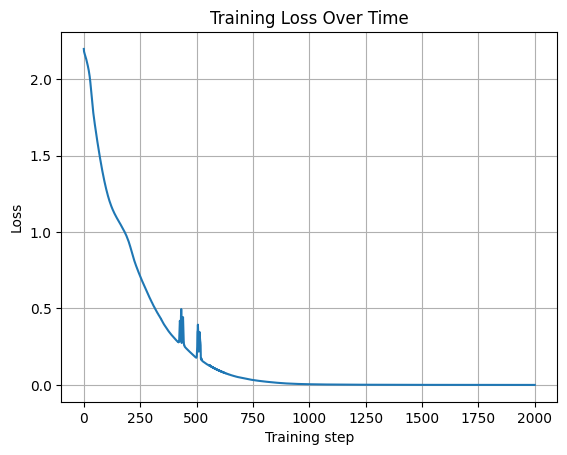

In [12]:

# === Visualization: Training Loss ===
plt.figure()
plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()


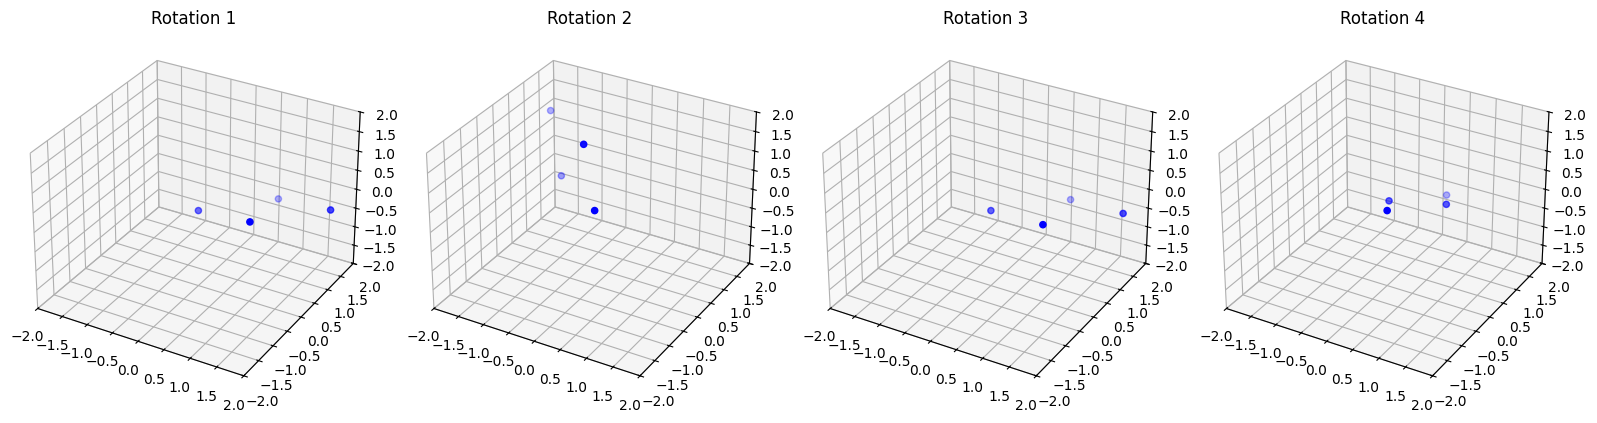

In [17]:
# === Corrected Cell: 3D Rotation Invariance ===
from mpl_toolkits.mplot3d import Axes3D

def plot_shape_3d(points, ax, title=""):
    # Plotting x, y, z coordinates
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')
    
    # Setting limits to keep the scale consistent during rotation
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_title(title)

shape_id = 7  # Example: 'L' shape (Index 7 in your tetris list)
shape = dataset[shape_id]

fig = plt.figure(figsize=(16, 4))

for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    
    # Generate random rotation
    rot = utils.random_rotation_matrix(rng)
    
    # FIX: Use the full 3x3 rotation matrix (shape @ rot)
    # The paper deals with SO(3) rotations, so we keep all 3 dimensions.
    rotated = np.dot(shape, rot) 
    
    plot_shape_3d(rotated, ax, f"Rotation {i+1}")

plt.tight_layout()
plt.show()

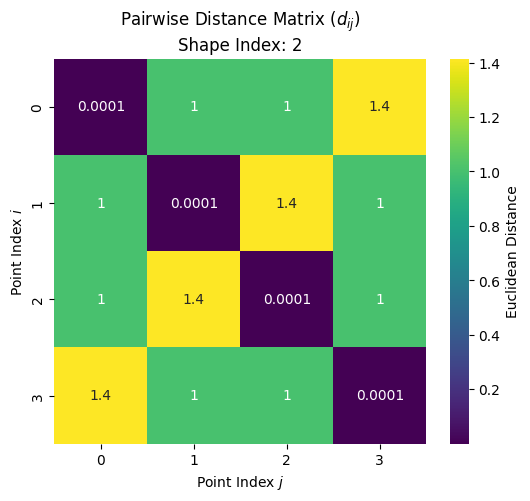

In [20]:
# === Visualization: Pairwise Distance Matrix ===
import seaborn as sns

# Calculate distance matrix for a sample shape
shape_idx = 2 # Square shape
r_sample = tf.constant(dataset[shape_idx], dtype=FLOAT_TYPE)
dij_tensor = utils.distance_matrix(r_sample)

# Run session to get values (since you are using TF 1.x / compat v1)
with tf.compat.v1.Session() as sess:
    dij_values = sess.run(dij_tensor)

plt.figure(figsize=(6, 5))
sns.heatmap(dij_values, annot=True, cmap="viridis", cbar_kws={'label': 'Euclidean Distance'})
plt.title(f"Pairwise Distance Matrix ($d_{{ij}}$)\nShape Index: {shape_idx}")
plt.xlabel("Point Index $j$")
plt.ylabel("Point Index $i$")
plt.show()

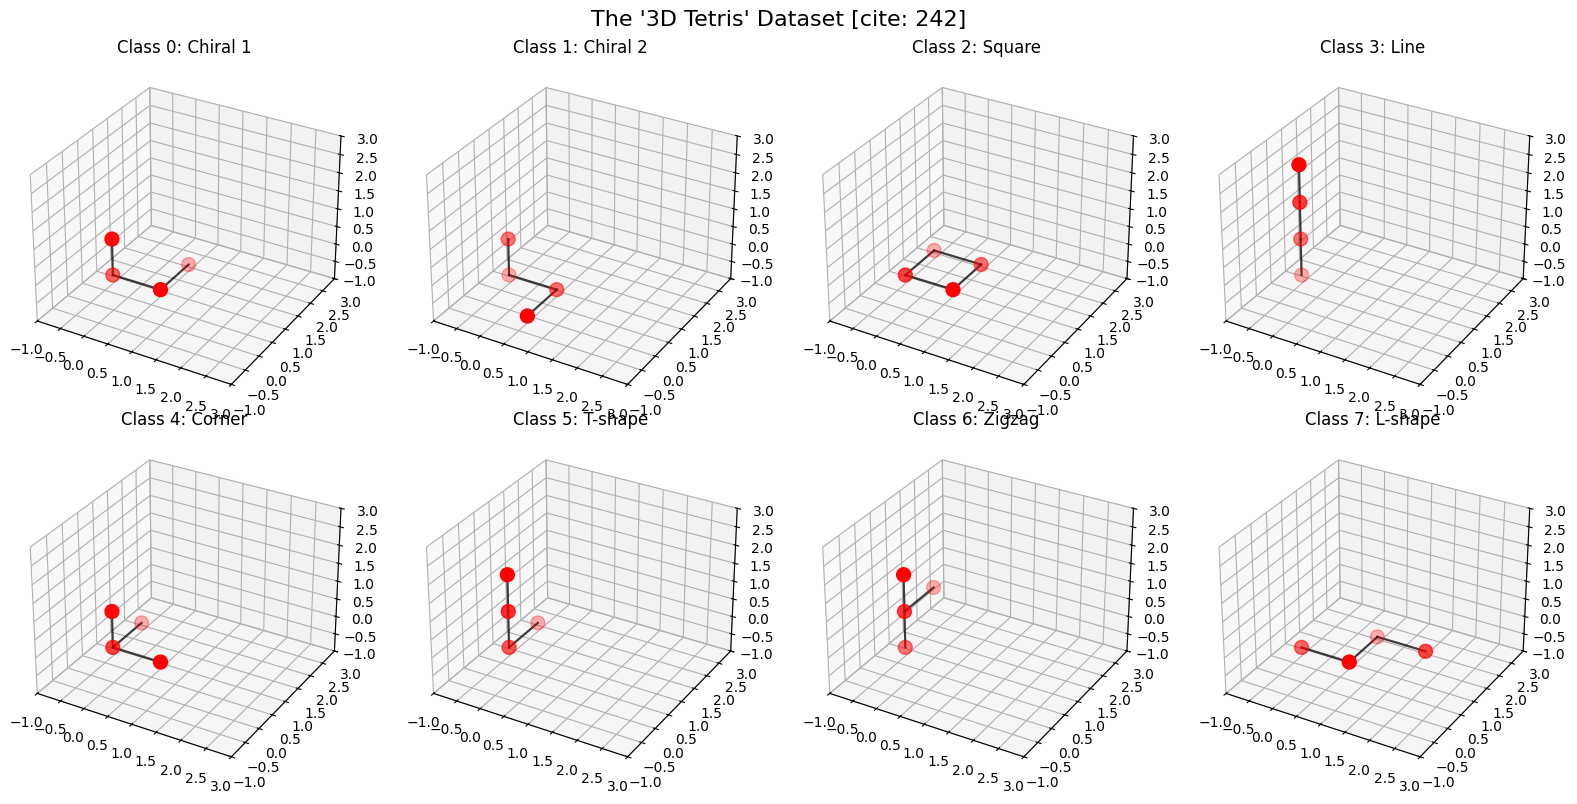

In [21]:
# === Visualization: All 3D Tetris Shapes ===
fig = plt.figure(figsize=(16, 8))
shape_names = ['Chiral 1', 'Chiral 2', 'Square', 'Line', 'Corner', 'T-shape', 'Zigzag', 'L-shape']

for i in range(len(dataset)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    points = dataset[i]
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=100, c='red')
    
    # Draw lines between points to visualize "structure" (optional heuristic connecting near points)
    for p1 in points:
        for p2 in points:
            if np.linalg.norm(p1-p2) == 1.0: # Connect neighbors
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', alpha=0.5)

    ax.set_title(f"Class {i}: {shape_names[i]}")
    ax.set_xlim([-1, 3])
    ax.set_ylim([-1, 3])
    ax.set_zlim([-1, 3])

plt.suptitle("The '3D Tetris' Dataset [cite: 242]", fontsize=16)
plt.tight_layout()
plt.show()

In [22]:
import numpy as np
import itertools

def sorted_pairwise_distances(X):
    # X: (N, d) points
    D = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            D.append(np.linalg.norm(X[i] - X[j]))
    return np.sort(np.array(D))

# Find candidate mirror pairs: same distance multiset
dist_signatures = [sorted_pairwise_distances(s) for s in dataset]

pairs = []
for i, j in itertools.combinations(range(len(dataset)), 2):
    if np.allclose(dist_signatures[i], dist_signatures[j], atol=1e-8):
        pairs.append((i, j))

print("Distance-indistinguishable pairs:", pairs)


Distance-indistinguishable pairs: [(0, 1)]


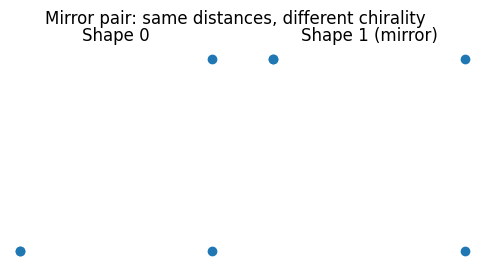

In [23]:
def show_two_shapes(i, j):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].scatter(dataset[i][:,0], dataset[i][:,1])
    ax[0].set_title(f"Shape {i}")
    ax[1].scatter(dataset[j][:,0], dataset[j][:,1])
    ax[1].set_title(f"Shape {j} (mirror)")
    for a in ax:
        a.set_aspect("equal")
        a.axis("off")
    plt.suptitle("Mirror pair: same distances, different chirality")
    plt.show()

# use the first found pair
i, j = pairs[0]
show_two_shapes(i, j)


In [27]:
import numpy as np
import tensorflow as tf

# --- 1) Make sure we have an open session ---
try:
    sess.run(tf.constant(0))  # quick ping
except Exception:
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())

# --- 2) (Optional) retrain if you haven't trained in this kernel ---
# If you've already trained in THIS same kernel run, you can skip this block.
max_epochs = 2001
print_freq = 100

loss_history = []
for epoch in range(max_epochs):
    loss_sum = 0.0
    for label, shape in enumerate(dataset):
        loss_value, _ = sess.run([loss, train_op], feed_dict={r: shape, tf_label: label})
        loss_sum += loss_value

    avg_loss = loss_sum / len(dataset)
    loss_history.append(avg_loss)

    if epoch % print_freq == 0:
        print("Epoch %d: loss = %.3f" % (epoch, avg_loss))

# --- 3) Mirror-pair rotation + translation test ---
def predict_shape(shape):
    logits = sess.run(output, feed_dict={r: shape})
    return int(np.argmax(logits))

def rotation_test(shape, trials=50, translate=True):
    preds = []
    for _ in range(trials):
        R = utils.random_rotation_matrix(rng)
        R3 = R[:3, :3]
        rotated = shape @ R3.T

        if translate:
            t = rng.randn(3)
            rotated = rotated + t

        preds.append(predict_shape(rotated))
    return preds

# mirror pair found earlier
i, j = 0, 1

preds_i = rotation_test(dataset[i], trials=50, translate=True)
preds_j = rotation_test(dataset[j], trials=50, translate=True)

print(f"Shape {i} predicted labels (unique):", sorted(set(preds_i)))
print(f"Shape {j} predicted labels (unique):", sorted(set(preds_j)))
print(f"Shape {i} counts:", {k: preds_i.count(k) for k in set(preds_i)})
print(f"Shape {j} counts:", {k: preds_j.count(k) for k in set(preds_j)})


Epoch 0: loss = 2.150
Epoch 100: loss = 0.435
Epoch 200: loss = 0.140
Epoch 300: loss = 0.005
Epoch 400: loss = 0.001
Epoch 500: loss = 0.000
Epoch 600: loss = 0.000
Epoch 700: loss = 0.000
Epoch 800: loss = 0.000
Epoch 900: loss = 0.000
Epoch 1000: loss = 0.000
Epoch 1100: loss = 0.000
Epoch 1200: loss = 0.000
Epoch 1300: loss = 0.000
Epoch 1400: loss = 0.000
Epoch 1500: loss = 0.000
Epoch 1600: loss = 0.000
Epoch 1700: loss = 0.000
Epoch 1800: loss = 0.000
Epoch 1900: loss = 0.000
Epoch 2000: loss = 0.000
Shape 0 predicted labels (unique): [0]
Shape 1 predicted labels (unique): [1]
Shape 0 counts: {0: 50}
Shape 1 counts: {1: 50}
